In [16]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import os
from PIL import Image
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from image.models import Image
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet, MIMSAlignment
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims
import pprint
import cv2

/Users/chris/miniforge3/envs/bioio/lib/python3.12/site-packages/django/db/models/base.py:366: RuntimeWarning: Model 'mims.isotope' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/Users/chris/miniforge3/envs/bioio/lib/python3.12/site-packages/django/db/models/base.py:366: RuntimeWarning: Model 'mims.mimsimageset' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/Users/chris/miniforge3/envs/bioio/lib/python3.12/site-packages/django/db/models/base.py:366: RuntimeWarning: Model 'mims.mimsimage_isotopes' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label,

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#viewset = MIMSImageSet.objects.get(id="9187111a-7b13-41ea-a3d8-69a0b372b31c")
#print([m for m in viewset.mims_images.all()])
im = sims.SIMS("/Users/chris/Documents/lab/NanoSIMS-HR data _1st day_/NMJ_Section_5_2.im")
print(im.data.shape)
#pprint.pprint(im.header)
mims_meta = im.header["Image"]
print(mims_meta)
mims_pixel_size = mims_meta["raster"] / mims_meta["width"]
print(mims_meta["raster"], mims_meta["width"], mims_pixel_size)


(7, 4, 512, 512)
{'header size': 84, 'type': 1, 'width': 512, 'height': 512, 'bytes per pixel': 4, 'masses': 7, 'planes': 4, 'raster': 5000, 'original filename': 'NMJ_Section_5_c.im'}
5000 512 9.765625


In [15]:
import numpy as np
from skimage.transform import estimate_transform
import sims
from mims.models import MIMSImage, MIMSImageSet, MIMSAlignment
from PIL import Image
import math
from mims.model_utils import (
    get_concatenated_image,
    get_autocontrast_image_path,
)
import cv2
from PIL import ImageOps
import time

def largest_inner_square(side_length, angle):
    """Calculate the largest possible inner square side length for a given rotation angle."""
    # Convert angle to radians
    return side_length / (
        abs(math.cos(math.radians(angle))) + abs(math.sin(math.radians(angle)))
    )
def calculate_individual_mims_translations(mims_imageviewset, isotope):
    start = time.time()
    # Print seconds elapsed
    mims_images = mims_imageviewset.mims_images.all()
    # Get transformation parameters
    flip = mims_imageviewset.flip
    rotation_degrees = mims_imageviewset.rotation_degrees
    composite_image = Image.fromarray(
        get_concatenated_image(mims_imageviewset, isotope)
    )
    if isotope == "32S":
        composite_image = ImageOps.invert(composite_image)
    composite_image = composite_image.rotate(-rotation_degrees, expand=True)
    if flip:
        composite_image = composite_image.transpose(Image.FLIP_LEFT_RIGHT)
    composite_image = np.array(composite_image)
    em_image_obj = mims_imageviewset.canvas.images.first()
    scale = mims_imageviewset.pixel_size_nm / (em_image_obj.pixel_size_nm or 5)
    # Load the EM image as a numpy array
    em_image = Image.open(em_image_obj.file.path)
    em_image_array = np.array(em_image)
    scaled_em = cv2.resize(
        em_image_array,
        (int(em_image_array.shape[1] / scale), int(em_image_array.shape[0] / scale)),
    )
    # Calculate and store translations for each MIMS image
    for mims_image in mims_images[0:1]:
        filename = mims_image.file.name.split("/")[-1].split(".")[0]
        roi = filename.split("_")[-1]
        print(roi, "time1", time.time() - start)
        # Load the MIMS image for the isotope and load as PIL image
        img_orig = get_autocontrast_image_path(mims_image, isotope)
        img_orig = Image.open(img_orig)
        if isotope == "32S":
            img_orig = ImageOps.invert(img_orig)
        img = img_orig.copy()
        # Apply the flip and rotation if necessary to it
        img = img.rotate(-rotation_degrees, expand=True)
        if flip:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        img_array = np.array(img)

        # Calculate the center of the image
        center_x, center_y = img_array.shape[1] // 2, img_array.shape[0] // 2

        # Calculate the cropping box
        largest_inner_square_side = int(
            largest_inner_square(img_orig.width, rotation_degrees)
        )
        start_x = center_x - largest_inner_square_side // 2
        start_y = center_y - largest_inner_square_side // 2
        end_x = center_x + largest_inner_square_side // 2
        end_y = center_y + largest_inner_square_side // 2

        # Crop the image to the largest inner square
        cropped_img_array = img_array[start_y:end_y, start_x:end_x]
        orig_cropped_img_array_shape = cropped_img_array.shape

        # Then find the image in the composite image
        result = cv2.matchTemplate(composite_image, img_array, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        # Now from this approximation, find a closer match in the actual EM image
        # Find the original EM location of the MIMS image
        print("hmm", max_loc, mims_imageviewset.canvas_y, mims_imageviewset.canvas_x, scale)
        mims_y = mims_imageviewset.canvas_y + max_loc[1] * scale
        mims_x = mims_imageviewset.canvas_x + max_loc[0] * scale
        mims_scaled_shape = np.array(img_orig).shape
        em_orig_shape = em_image_array.shape
        # Skip if sufficiently far outside of the known EM bounds
        approx_em_loc = [mims_y, mims_x]
        print("????", approx_em_loc, em_orig_shape, mims_scaled_shape)
        if (
            approx_em_loc[0] < -mims_scaled_shape[0]
            or approx_em_loc[0] > em_orig_shape[0] + mims_scaled_shape[0]
            or approx_em_loc[1] < -mims_scaled_shape[1]
            or approx_em_loc[1] > em_orig_shape[1] + mims_scaled_shape[1]
        ):
            print("Out of bounds: ", approx_em_loc, em_orig_shape)
            mims_image.status = "OUTSIDE_CANVAS"
            mims_image.save()
            continue
        print("Seems in bounds:", approx_em_loc, em_orig_shape)
        # Then scale it down
        mims_y_scaled = mims_y / scale
        mims_x_scaled = mims_x / scale
        crop_size = int(img_array.shape[0] * 1.3)
        amt_to_add_back = crop_size * 0.5
        crop_y_start = max(mims_y_scaled - amt_to_add_back, 0)
        crop_y_end = min(mims_y_scaled + (crop_size * 1.5), scaled_em.shape[0])
        crop_x_start = max(mims_x_scaled - amt_to_add_back, 0)
        crop_x_end = min(mims_x_scaled + (crop_size * 1.5), scaled_em.shape[1])
        scaled_em_crop = scaled_em[
            int(crop_y_start) : int(crop_y_end), int(crop_x_start) : int(crop_x_end)
        ]
        y_size_limit = int(scaled_em.shape[0] - mims_y_scaled)
        if (y_size_limit) < cropped_img_array.shape[0]:
            if crop_y_start == 0:
                cropped_img_array = cropped_img_array[-y_size_limit:, :]
            else:
                cropped_img_array = cropped_img_array[:y_size_limit, :]
        x_size_limit = int(scaled_em.shape[1] - mims_x_scaled)
        if (x_size_limit) < cropped_img_array.shape[1]:
            if crop_x_start == 0:
                cropped_img_array = cropped_img_array[:, -x_size_limit:]
            else:
                cropped_img_array = cropped_img_array[:, :x_size_limit]
        # Now find the MIMS image in the crop
        # These 2 calls take ~0.3 seconds
        if cropped_img_array.shape[0] == 0 or cropped_img_array.shape[1] == 0:
            mims_image.status = "NO_CELLS"
            mims_image.save()
            continue
        result = cv2.matchTemplate(
            scaled_em_crop, cropped_img_array, cv2.TM_CCOEFF_NORMED
        )
        _, _, _, max_loc = cv2.minMaxLoc(result)
        scaled_cropped_em_y_start = max(max_loc[1], 0)
        scaled_em_y_start = int(crop_y_start + scaled_cropped_em_y_start)
        em_y_start = int(scaled_em_y_start * scale)
        scaled_cropped_em_x_start = max(max_loc[0], 0)
        scaled_em_x_start = int(crop_x_start + scaled_cropped_em_x_start)
        em_x_start = int(scaled_em_x_start * scale)

        mims_image.alignments.all().delete()
        mims_image.alignments.create(
            x_offset=em_x_start,
            y_offset=em_y_start,
            flip_hor=flip,
            rotation_degrees=rotation_degrees,
            scale=scale,
            status="GUESS",
        )
        mims_image.status = "NEED_USER_ALIGNMENT"
        mims_image.save()
    return

viewset = MIMSImageSet.objects.get(id="af036a54-30db-4bf1-8376-40c519b8b20a")
calculate_individual_mims_translations(viewset, "SE")


0 time1 7.6144819259643555
hmm (3402, 2467) -22133 -7162 13.40419359524007
???? [10935.145599457253, 38439.06661100672] (47709, 34959) (512, 512)
Out of bounds:  [10935.145599457253, 38439.06661100672] (47709, 34959)


10934.667999999998
45600.408


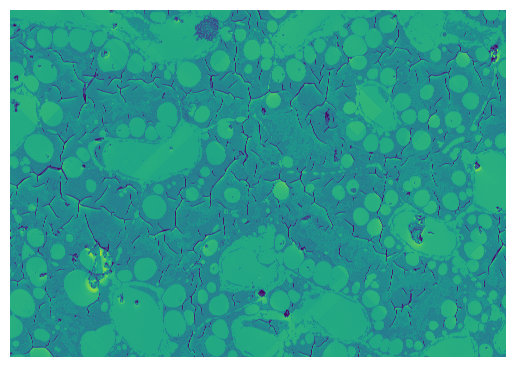

In [14]:
import numpy as np
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import tifffile

img_name = "24-479_R16_05GlutFed_ImmunoEM_GK_se2"

# Load the image into a numpy array
image_folder = "/Users/chris/Documents/lab/experiments/2024_ImmunoEM-test-GK/2024-12-19-ImmunoEM"
image_path = os.path.join(image_folder, f"{img_name}.tif")
large_image = imread(image_path)

# Define the cropping bounds (rows, cols)
start_row, end_row = 5000, 19000
start_col, end_col = 30000, 50000
cropped_image = large_image[start_row:end_row, start_col:end_col]
outpath = os.path.join(image_folder, f"{img_name}_cropped.tif")
cropped_image = cropped_image.astype(np.uint8)
tifffile.imwrite(outpath, cropped_image)

# Display or save the cropped image
plt.imshow(cropped_image)
plt.axis("off")
plt.show()

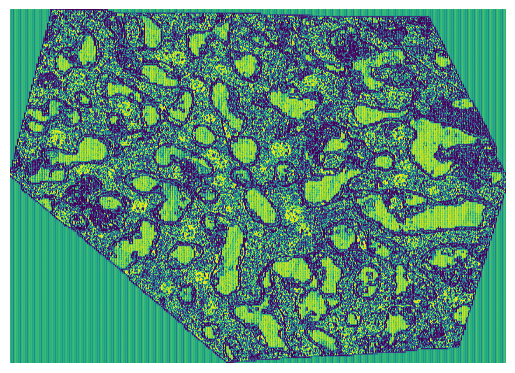

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
# Specify the path to your PNG image file
image_path = '/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/Mitos-8bit/processed_25_0582-5nm-R2.tif'  # Replace with the actual path to your PNG file

# Read the image data
img = mpimg.imread(image_path)


# Display the image
plt.imshow(img)

# Optional: Remove axis ticks and labels for a cleaner image display
plt.axis('off')

# Show the plot
plt.show()

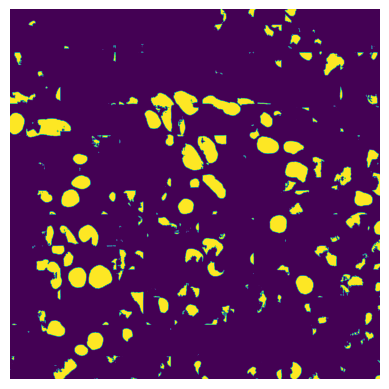

In [9]:
import numpy as np
img_subset = img[12000:15000, 9000:12000]
# Threshold to .95
img_subset = img_subset > (0.98 * 255)
plt.imshow(img_subset)

# Optional: Remove axis ticks and labels for a cleaner image display
plt.axis('off')

# Show the plot
plt.show()

In [4]:
# Now show the other image
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
em_path = '/Users/chris/Documents/lab/experiments/2025-0610-diazoxide/EM/25_0582-5nm-R2.tif'
img_em = mpimg.imread(em_path)


(np.float64(-0.5), np.float64(2999.5), np.float64(2999.5), np.float64(-0.5))

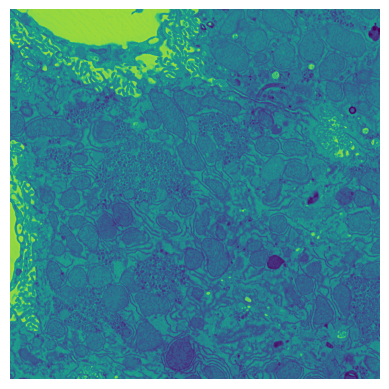

In [28]:
img_em_subset = img_em[12000:15000, 9000:12000]

# Display the image
plt.imshow(img_em_subset)

# Optional: Remove axis ticks and labels for a cleaner image display
plt.axis('off')